In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
#4/0AEpufuJ_nbX2dmW9b_yXFnB9ZujzNhSBbcBUvxn2H0lTVVMyz4e-Q0

In [0]:
pip install neptune-client

In [0]:
import neptune

neptune.init(
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZjY2Y2M1MjktNzljYy00MTFjLWE1NTQtOTAxYTFhMmNjM2VhIn0=",
    project_qualified_name="joey0320/reverse-2"
)

Project(joey0320/reverse-2)

In [0]:
import sys
sys.path.append('/content/libs')

In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
from DataCaller import DataCaller
from EarlyStopper import *
from Net import *
from train_test import *
from utils import *

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
config = {
    'load_data':True,
    'load_test_data':True,

    'batch_size':12,
    'val_batch_size':16,
    'learning_rate':2e-4,
    'epochs':1000,
    'patience':3,

    'img_size':64,
    'img_channels':4,

    'train_label_size':6,
    #'test_label_size':3,
    'test_label_size':6,

    'output1':2,
    'output2':2,
    'result_label':4,

    'weight':torch.tensor([1.0, 1.0, 1.0, 0.1]),
}
MODEL_NAME = f"model-{int(time.time())}"
neptune.create_experiment(name='rev1', params=config, upload_source_files=['libs/DataCaller.py',
                                                                           'libs/EarlyStopper.py',
                                                                           'libs/Net.py',
                                                                           'libs/train_test.py',
                                                                           'libs/utils.py'])


cuda
https://ui.neptune.ai/joey0320/reverse-2/e/REV1-108


Experiment(REV1-108)

In [0]:
BASE_PATH = '/content/gdrive/My Drive/Colab Notebooks/Reverse_Method_Horn/data'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, '8th_gen/train')
VAL_DATA_PATH = os.path.join(BASE_PATH, '8th_gen/val')
TEST_DATA_PATH = os.path.join(BASE_PATH, '8th_gen/test')

In [0]:
if config['load_data']:
    trainsets = []
    valsets = []
    for f in tqdm(os.listdir(TRAIN_DATA_PATH)):
      path = os.path.join(TRAIN_DATA_PATH, f)
      trainset = DataCaller(path, config['img_size'], config['train_label_size'])
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_DATA_PATH)):
      path  = os.path.join(VAL_DATA_PATH, f)
      valset = DataCaller(path, config['img_size'], config['train_label_size'])
      print(valset.__len__())
      valsets.append(valset)

if config['load_test_data']:
    testsets = []
    for f in tqdm(os.listdir(TEST_DATA_PATH)):
      path  = os.path.join(TEST_DATA_PATH, f)
      testset = DataCaller(path, config['img_size'], config['test_label_size'])
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())  

In [0]:
   #define dataloaders
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle=True)
valloader = DataLoader(valset, batch_size=config['batch_size'], shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [0]:
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    filter_input(x)
    x = np.array(x)
    x = x.reshape(-1, config['img_channels'], config['img_size'], config['img_size'])

    print(x.shape)
    print(x[0])
    print(x[0].shape)

    print(y[0])
    cnt += 1
    if cnt==1:
      break

In [0]:
net = Net(config['img_channels'], config['output1'], config['output2'])
net.to(device)
print(net)
train_losses, valid_losses = train(net, trainloader, valloader, config['weight'], config['epochs'], config['learning_rate'], 
                                   config['img_channels'], config['img_size'], MODEL_NAME, 
                                   config['patience'], 1, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

Net(
  (cnn): Sequential(
    (0): Conv2d(4, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(

  0%|          | 1/1000 [00:13<3:41:16, 13.29s/it]


loss :  2.8849232005505336 val loss :  0.9407603771258624 

Validation loss decreased (inf --> 0.940760).  Saving model ...


  0%|          | 2/1000 [00:25<3:37:10, 13.06s/it]


loss :  0.5836545308218116 val loss :  0.33958133068094903 

Validation loss decreased (0.940760 --> 0.339581).  Saving model ...


  0%|          | 3/1000 [00:38<3:33:58, 12.88s/it]


loss :  0.3344313992347036 val loss :  0.33228936835996103 

Validation loss decreased (0.339581 --> 0.332289).  Saving model ...


  0%|          | 4/1000 [00:50<3:31:41, 12.75s/it]


loss :  0.24451312197106226 val loss :  0.19736042414974964 

Validation loss decreased (0.332289 --> 0.197360).  Saving model ...


  0%|          | 5/1000 [01:03<3:31:27, 12.75s/it]


loss :  0.19790836715982074 val loss :  0.2318721279883996 

EarlyStopping counter: 1 out of 3


  1%|          | 6/1000 [01:15<3:29:33, 12.65s/it]


loss :  0.16641905915701674 val loss :  0.15066084001436192 

Validation loss decreased (0.197360 --> 0.150661).  Saving model ...


  1%|          | 7/1000 [01:28<3:28:38, 12.61s/it]


loss :  0.14625493056894767 val loss :  0.12619350557653314 

Validation loss decreased (0.150661 --> 0.126194).  Saving model ...


  1%|          | 8/1000 [01:41<3:28:29, 12.61s/it]


loss :  0.122872877381742 val loss :  0.11322537261960852 

Validation loss decreased (0.126194 --> 0.113225).  Saving model ...


  1%|          | 9/1000 [01:53<3:27:44, 12.58s/it]


loss :  0.1120551844100867 val loss :  0.11363584527538882 

EarlyStopping counter: 1 out of 3


  1%|          | 10/1000 [02:06<3:27:20, 12.57s/it]


loss :  0.10133295245468617 val loss :  0.10047816507454611 

Validation loss decreased (0.113225 --> 0.100478).  Saving model ...


  1%|          | 11/1000 [02:18<3:26:40, 12.54s/it]


loss :  0.0914642735304577 val loss :  0.08978581003462657 

Validation loss decreased (0.100478 --> 0.089786).  Saving model ...


  1%|          | 12/1000 [02:31<3:26:27, 12.54s/it]


loss :  0.07976198758486482 val loss :  0.07537660056836584 

Validation loss decreased (0.089786 --> 0.075377).  Saving model ...


  1%|▏         | 13/1000 [02:43<3:26:01, 12.52s/it]


loss :  0.07548685878249152 val loss :  0.1743742515707118 

EarlyStopping counter: 1 out of 3


  1%|▏         | 14/1000 [02:56<3:26:07, 12.54s/it]


loss :  0.0742076341985237 val loss :  0.12108422596103106 

EarlyStopping counter: 2 out of 3


  2%|▏         | 15/1000 [03:08<3:25:41, 12.53s/it]


loss :  0.06771801570519095 val loss :  0.0714508246184669 

Validation loss decreased (0.075377 --> 0.071451).  Saving model ...


  2%|▏         | 16/1000 [03:21<3:25:01, 12.50s/it]


loss :  0.06355047819248977 val loss :  0.07205651714824714 

EarlyStopping counter: 1 out of 3


  2%|▏         | 17/1000 [03:33<3:24:44, 12.50s/it]


loss :  0.057786574447971015 val loss :  0.07076196566733539 

Validation loss decreased (0.071451 --> 0.070762).  Saving model ...


  2%|▏         | 18/1000 [03:46<3:25:03, 12.53s/it]


loss :  0.055813684156608014 val loss :  0.06370908766188937 

Validation loss decreased (0.070762 --> 0.063709).  Saving model ...


  2%|▏         | 19/1000 [03:58<3:25:09, 12.55s/it]


loss :  0.05209537667710157 val loss :  0.06357436084276082 

Validation loss decreased (0.063709 --> 0.063574).  Saving model ...


  2%|▏         | 20/1000 [04:11<3:25:20, 12.57s/it]


loss :  0.0502945668161625 val loss :  0.06961764401604986 

EarlyStopping counter: 1 out of 3


  2%|▏         | 21/1000 [04:24<3:25:34, 12.60s/it]


loss :  0.045560777649904294 val loss :  0.04962037336558868 

Validation loss decreased (0.063574 --> 0.049620).  Saving model ...


  2%|▏         | 22/1000 [04:36<3:26:53, 12.69s/it]


loss :  0.04401236606229629 val loss :  0.051299543796568856 

EarlyStopping counter: 1 out of 3


  2%|▏         | 23/1000 [04:49<3:26:30, 12.68s/it]


loss :  0.04139122740498611 val loss :  0.06635351491789533 

EarlyStopping counter: 2 out of 3

loss :  0.03961801580552544 val loss :  0.05718733781837245 

EarlyStopping counter: 3 out of 3
Early stopping


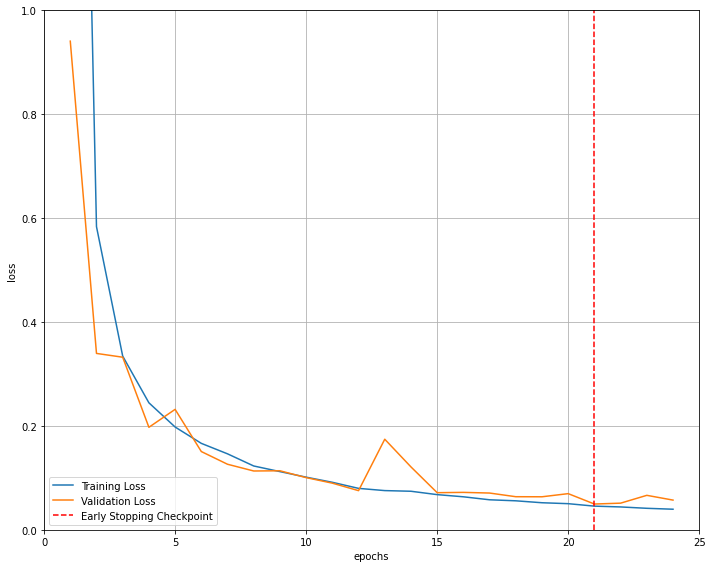

In [0]:
graph_limit = 1
save_plot(train_losses, valid_losses, graph_limit)
neptune.log_artifact('loss_plot.png')

In [0]:
net.load_state_dict(torch.load('checkpoint.pt'))

test(net, testloader, config['img_channels'], config['img_size'], config['result_label'], device)
neptune.log_artifact('predictions.xlsx')
neptune.log_artifact('model.log')

[array([[8.589835 , 2.4250226, 2.9630158, 0.7304061]], dtype=float32), array([[8.980608 , 2.8740015, 2.0409093, 0.7235248]], dtype=float32), array([[9.215814 , 1.3759123, 3.3743725, 0.7774575]], dtype=float32), array([[10.977724 ,  3.7080133,  3.4122272,  0.3207212]], dtype=float32), array([[4.5933223, 1.2575598, 1.5109808, 0.6726497]], dtype=float32), array([[13.0227165,  3.2323341,  5.0627503,  0.4085099]], dtype=float32), array([[8.401841 , 1.379627 , 3.0441794, 0.3632319]], dtype=float32), array([[10.827754 ,  3.489319 ,  2.8227806,  0.7724863]], dtype=float32), array([[11.718207  ,  2.146408  ,  3.967138  ,  0.77327955]],
      dtype=float32), array([[8.243809  , 1.9897159 , 2.6065402 , 0.26452917]], dtype=float32), array([[9.422667 , 4.010014 , 2.311899 , 0.8910941]], dtype=float32), array([[5.8428345 , 2.1922166 , 1.4888749 , 0.37723494]], dtype=float32), array([[13.386272 ,  2.1052911,  4.5548596,  0.3558321]], dtype=float32), array([[10.450664  ,  3.95651   ,  4.113355  ,  0.7

In [0]:
for num, data in enumerate(testloader):
  x, y = data
  print(y)

tensor([[  1.0000,   1.0000, 100.0000,   2.2307,   2.4746,   0.5550]])
tensor([[  1.0000,   1.0000, 100.0000,   2.6275,   1.7521,   0.6256]])
tensor([[  1.0000,   1.0000, 100.0000,   1.2984,   2.9501,   0.7766]])
tensor([[  1.0000,   1.0000, 100.0000,   2.6050,   2.8848,   0.2108]])
tensor([[  1.0000,   1.0000, 100.0000,   1.2331,   1.3928,   0.6470]])
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+02, 2.6344e+00, 3.3223e+00, 9.0136e-02]])
tensor([[  1.0000,   1.0000, 100.0000,   1.1994,   2.3670,   0.3209]])
tensor([[  1.0000,   1.0000, 100.0000,   3.2001,   1.9837,   0.6070]])
tensor([[  1.0000,   1.0000, 100.0000,   1.8521,   3.2129,   0.5673]])
tensor([[  1.0000,   1.0000, 100.0000,   1.7136,   2.2186,   0.1958]])
tensor([[  1.0000,   1.0000, 100.0000,   3.2345,   1.8220,   0.7678]])
tensor([[  1.0000,   1.0000, 100.0000,   1.9016,   1.2915,   0.3794]])
tensor([[  1.0000,   1.0000, 100.0000,   1.5538,   3.4321,   0.1363]])
tensor([[  1.0000,   1.0000, 100.0000,   2.9949,   2.9812,   0.71

In [0]:
neptune.log_artifact('description.txt')
